In [115]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# ---------------------- Filter to our wanted classes only ---------------------
# Define the classes you want to keep (e.g., class 0 and class 1)
classes = ('car', 'frog', 'horse', 'ship')
classes_to_keep = [1, 6, 7, 8]

# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Function to filter the dataset by the specified classes
def filter_dataset_by_class(dataset, classes):
    # Get the data and targets
    data, targets = dataset.data, torch.tensor(dataset.targets)

    # Create a mask for the classes you want to keep
    mask = torch.isin(targets, torch.tensor(classes))

    # Filter the data and targets
    filtered_data = data[mask.numpy()]
    filtered_targets = targets[mask].numpy()

    for i in range(len(filtered_targets)):
      filtered_targets[i] = classes.index(filtered_targets[i])

    # Update the dataset's data and targets
    dataset.data = filtered_data
    dataset.targets = filtered_targets

# Size of the unfiltered sets
print(f'Unfiltered train set size: {len(trainset)}')
print(f'Unfiltered test set size: {len(testset)}')
print(f'Unfiltered classes: {trainset.classes}')

# Filter the train and test sets
filter_dataset_by_class(trainset, classes_to_keep)
filter_dataset_by_class(testset, classes_to_keep)

# Now the trainset and testset objects are still CIFAR10 datasets, but only contain the selected classes
print(f'Filtered train set size: {len(trainset)}')
print(f'Filtered test set size: {len(testset)}')
print(f'Filtered classes: {trainset.classes}')

# Create DataLoader for the filtered datasets
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Example: Iterate through the filtered trainloader
for i, (images, labels) in enumerate(trainloader):
    print(f'Batch size: {images.size(0)}, Labels: {labels}')
    if i == 3:
      break

print(trainset)
print(testset)

Files already downloaded and verified
Files already downloaded and verified
Unfiltered train set size: 50000
Unfiltered test set size: 10000
Unfiltered classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Filtered train set size: 20000
Filtered test set size: 4000
Filtered classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch size: 4, Labels: tensor([2, 2, 0, 2])
Batch size: 4, Labels: tensor([3, 1, 1, 0])
Batch size: 4, Labels: tensor([0, 3, 2, 2])
Batch size: 4, Labels: tensor([2, 3, 0, 1])
Dataset CIFAR10
    Number of datapoints: 20000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 4000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
      

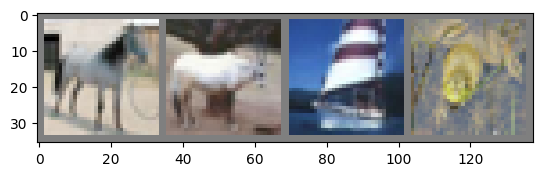

horse horse ship  frog 


In [170]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [158]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 8, 5)
        self.fc1 = nn.Linear(8 * 5 * 5, 40)
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [159]:
# Number of learnable parameters in the model
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(pytorch_total_params)

10608


In [160]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [161]:
def accuracy(net, test=False):
  # Let's test on the whole test-set
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  dataloader = testloader if test else trainloader
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          # calculate outputs by running images through the network
          outputs = net(images)
          loss = criterion(outputs, labels)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = 100 * correct // total
  # print(f'Accuracy of the network on the {"test" if test else "train"} images: {100 * correct // total} %')
  return accuracy, loss.item()


In [162]:
n_epochs = 40
train_accuracy = []
test_accuracy = []
train_losses = []
test_losses = []
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    n_samples = trainloader.dataset.data.shape[0]

    # Calculate train accuracy
    train_acc, train_loss = accuracy(net)
    train_accuracy.append(train_acc)
    train_losses.append(train_loss)

    # Calculate test accuracy
    test_acc, test_loss = accuracy(net, test=True)
    test_accuracy.append(test_acc)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}, Train accuracy: {train_acc}, Test accuracy: {test_acc}, Train loss: {train_loss}, Test loss: {test_loss}')

print('Finished Training')

[1,  2000] loss: 1.083
[1,  4000] loss: 0.685
Epoch 0, Train accuracy: 77, Test accuracy: 77, Train loss: 0.20221015810966492, Test loss: 0.4164787232875824
[2,  2000] loss: 0.560
[2,  4000] loss: 0.541
Epoch 1, Train accuracy: 82, Test accuracy: 81, Train loss: 0.7397783994674683, Test loss: 0.28637683391571045
[3,  2000] loss: 0.460
[3,  4000] loss: 0.471
Epoch 2, Train accuracy: 86, Test accuracy: 85, Train loss: 0.13752436637878418, Test loss: 0.17112626135349274
[4,  2000] loss: 0.415
[4,  4000] loss: 0.405
Epoch 3, Train accuracy: 87, Test accuracy: 85, Train loss: 0.41780197620391846, Test loss: 0.15264947712421417
[5,  2000] loss: 0.371
[5,  4000] loss: 0.371
Epoch 4, Train accuracy: 88, Test accuracy: 86, Train loss: 0.05125698447227478, Test loss: 0.22708739340305328
[6,  2000] loss: 0.333
[6,  4000] loss: 0.336
Epoch 5, Train accuracy: 88, Test accuracy: 86, Train loss: 2.173527956008911, Test loss: 0.10407013446092606
[7,  2000] loss: 0.317
[7,  4000] loss: 0.317
Epoch 6, T

In [163]:
dir_path = '/content/drive/MyDrive/MSc courses/OML project/4_class_cnn/15864/'

# Create a directory for the experiment
import os
os.makedirs(dir_path, exist_ok=True)

# Save the net
PATH = dir_path + 'model_15864.pth'
torch.save(net.state_dict(), PATH)

# Save the accuracy (train, test), and loss
df = pd.DataFrame({'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy, 'train_loss': train_losses, 'test_loss': test_losses})
df.to_csv(dir_path + 'results_15864.csv', index=False)

In [164]:
print(accuracy(net, test=False))
print(accuracy(net, test=True))

(96, 0.2017364501953125)
(87, 0.012958413921296597)


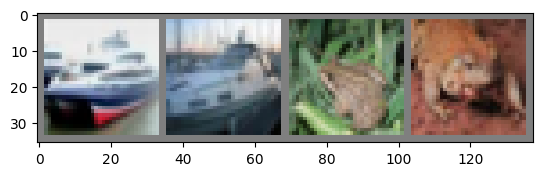

GroundTruth:  ship  ship  frog  frog 


In [174]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [175]:
# Load the network we learned
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [176]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  ship  ship  frog  frog 


In [171]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: car   is 89.3 %
Accuracy for class: frog  is 91.2 %
Accuracy for class: horse is 85.9 %
Accuracy for class: ship  is 84.1 %


The outcome we want:
A graph of the test error vs. the number of parameters.
We want to show the double-descent phenomenon.

Additions:
- We want to show the train-error as well - possibly on the same graph as the test error.
- A graph of the convergance time (# of epochs) vs. the number of parameters (?) Something like this. Can be nice to talk about the convergance time maybe.

The experiments that we want to do:
- We want to have at least 15 data-points (we may need more).
- So we will make at least 15 neural networks with different # of parameters approximately uniform between 10000-50000.
- For each experiment, we save the following:
  - All train and test accuracy, and loss values throughout the learning process (saved to csv file).


The order of experiments: 40 epochs of each experiments
Raz will run: From 12000 and up until 30000, with ~3000 granularity
Itay will run: From 45000 and down to 30000, with ~3000 granularity